In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import scipy.stats as sps
import seaborn as sns
import pandas as pd
import numpy as np
import csv

import plot_utils
from util import INST_NAME_ALIASES, binomial_confidence_interval, load_in_data
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import statsmodels.stats.api as sms

from matplotlib import ticker
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

%matplotlib inline

/Users/allisonmorgan/Dropbox/Faculty Social Mobility/code/plot_utils.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [


Read in the data and translate columns with category mappings to numerica values.

In [2]:
respondents_zip = pd.read_csv('../data/coded_data/data_linked.csv', low_memory=False)

In [3]:
# Careful here--codes switched between 2017 and 2018/2020. Effectively drops CS responses
# 2017 scale is:  None at all, A little, A lot, Not applicable 
# print(respondents_zip['support_family'].value_counts())
respondents_zip['support_family'] = respondents_zip['support_family'].map({'5':5, '4':4, '3':3, '2':2, '1':1})
respondents_zip['support_parents'] = respondents_zip['support_parents'].map({'5':5, '4':4, '3':3, '2':2, '1':1})
respondents_zip['support_partner'] = respondents_zip['support_partner'].map({'5':5, '4':4, '3':3, '2':2, '1':1})
respondents_zip['support_friends'] = respondents_zip['support_friends'].map({'5':5, '4':4, '3':3, '2':2, '1':1})
respondents_zip['support_collsin'] = respondents_zip['support_collsin'].map({'5':5, '4':4, '3':3, '2':2, '1':1})
respondents_zip['support_collsout'] = respondents_zip['support_collsout'].map({'5':5, '4':4, '3':3, '2':2, '1':1})
# respondents_zip['support_family'].value_counts()

In [4]:
## Add in PhD prestige?
max_dept_usnwr = respondents_zip.groupby(['likely_department'])['phd_USNWR'].max()
max_dept_nrc = respondents_zip.groupby(['likely_department'])['phd_NRC'].max()

def rank_scalar(row):
    if (row['likely_department'] in max_dept_usnwr) and not np.isnan(max_dept_usnwr[row['likely_department']]):
        return 100*np.divide(row['phd_USNWR'], max_dept_usnwr[row['likely_department']])
    elif (row['likely_department'] in max_dept_nrc) and not np.isnan(max_dept_nrc[row['likely_department']]):
        return 100*np.divide(row['phd_NRC'], max_dept_nrc[row['likely_department']])
    else:
        return np.nan

respondents_zip['phd_rank_scaled'] = respondents_zip.apply(rank_scalar, axis=1)
respondents_zip['phd_rank_scaled'].isna().value_counts()

False    4929
True     3080
Name: phd_rank_scaled, dtype: int64

In [5]:
# Translate categories to numerical values
# print(respondents_zip['current_geo'].value_counts())
respondents_zip['current_geo'] = respondents_zip['current_geo'].map({'Very important':3, 'Somewhat':2,
                                                                     'Not important':1,})
# respondents_zip['current_geo'].value_counts()

In [6]:
# Parents had PhD as a binary indicator.
respondents_zip['parents_had_phd'] = (respondents_zip['parents_highest_edu_coded'] == 'Doctoral degree')
respondents_zip.loc[respondents_zip['parents_highest_edu_coded'].isna(), 'parents_had_phd'] = np.nan

In [7]:
respondents_zip['parents_highest_edu_coded'].value_counts(normalize=True)

Master's or professional degree    0.296019
Doctoral degree                    0.222500
College: 4+ years                  0.195173
High school: 4 years               0.136912
College: 1-3 years                 0.094743
High school: 1-3 years             0.029130
Elementary: 0-8 years              0.025524
Name: parents_highest_edu_coded, dtype: float64

### Distributions of current placement prestige by parents have doctoral degree

1st Gen	 5069
Not	 1470
MannwhitneyuResult(statistic=3235964.5, pvalue=7.622465432846486e-15)


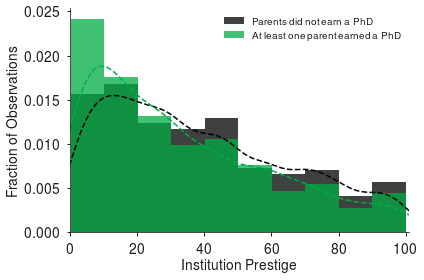

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=plot_utils.SINGLE_FIG_SIZE)
prestige_range = np.arange(0, 300); doctoral_label = 'Doctoral degree'

first_gen_doctorate = respondents_zip[~respondents_zip['parents_had_phd'].isna() & 
                                      (respondents_zip['parents_had_phd'] == 0)].rank_scaled.dropna()
print('1st Gen\t', len(first_gen_doctorate))
plt.hist(first_gen_doctorate, color='black', density=True, label = "Parents did not earn a PhD", alpha=0.75)
plt.plot(prestige_range, sps.gaussian_kde(first_gen_doctorate).pdf(prestige_range), 
         label=None, color='black', linestyle='--')

not_first_gen_doctorate = respondents_zip[~respondents_zip['parents_had_phd'].isna() & 
                                          (respondents_zip['parents_had_phd'] == 1)].rank_scaled.dropna()
print('Not\t', len(not_first_gen_doctorate))
plt.hist(not_first_gen_doctorate, color=plot_utils.ACCENT_COLOR, density=True, 
         label = "At least one parent earned a PhD", alpha=0.75)
plt.plot(prestige_range, sps.gaussian_kde(not_first_gen_doctorate).pdf(prestige_range), 
         label=None, color=plot_utils.ACCENT_COLOR, linestyle='--')

plt.xlabel('Institution Prestige', size=plot_utils.LABEL_SIZE)
plt.ylabel('Fraction of Observations', size=plot_utils.LABEL_SIZE)
plt.legend(frameon=False)

print(mannwhitneyu(first_gen_doctorate, not_first_gen_doctorate))

plt.xlim(0, 101)
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/prestige_p1p2_doctor.pdf', dpi=1000)

Grouping respondents by parent's highest education level, we can see current placement increases as parents' highest eductaion increases.

In [9]:
respondents_zip.groupby(['parents_highest_edu_coded'])['rank_scaled'].describe()

,count,mean,std,min,25%,50%,75%,max
parents_highest_edu_coded,,,,,,,,
College: 1-3 years,612.0,40.594504,27.321117,0.425532,17.972350,35.484987,59.677419,100.0
College: 4+ years,1276.0,38.344425,26.288177,0.425532,16.595745,32.795699,56.849315,100.0
Doctoral degree,1470.0,33.285734,26.601761,0.425532,10.752688,26.382979,50.000000,100.0
Elementary: 0-8 years,173.0,42.655107,26.581571,0.537634,19.178082,41.474654,62.328767,100.0
High school: 1-3 years,196.0,40.621510,27.802670,0.425532,16.648936,36.943164,61.868687,100.0
High school: 4 years,882.0,41.581818,27.552328,0.425532,17.972350,37.327189,60.368664,100.0
Master's or professional degree,1930.0,37.027710,27.081390,0.425532,14.042553,31.063830,56.565657,100.0


### Trends in parents with college degree or higher

In [10]:
total_data = []; field_data = []; discs = respondents_zip.likely_department.dropna().unique()
cis_more_than = []; cis_less_than = []; cis_phd_parents = [];
more_than_college_degree = ['College: 4+ years', "Master's or professional degree", 'Doctoral degree']
less_than_college_degree = ['Elementary: 0-8 years', 'High school: 1-3 years', 'High school: 4 years', 
                            'College: 1-3 years']
year_couples = [(1940, 1945), (1945, 1950), (1950, 1955), (1955, 1960), (1960, 1965), (1965, 1970), 
                (1970, 1975), (1975, 1980), (1980, 1985), (1985, 1990)]
for year_start, year_end in year_couples:
    born_in_year = respondents_zip[(respondents_zip.age_coded >= year_start) & \
                                   (respondents_zip.age_coded < year_end)].copy()
    # print(len(born_in_year), (year_start, year_end))
    
    
    more_than_college = born_in_year['parents_highest_edu_coded'].dropna().isin(more_than_college_degree)
    cis_more_than.append(binomial_confidence_interval(more_than_college)) 
    less_than_college = born_in_year['parents_highest_edu_coded'].dropna().isin(less_than_college_degree)
    cis_less_than.append(binomial_confidence_interval(less_than_college))
    
    phds = born_in_year['parents_highest_edu_coded'].dropna().isin(['Doctoral degree'])
    cis_phd_parents.append(binomial_confidence_interval(phds))
    # print(dict(born_in_year['parents_highest_edu_coded'].value_counts(normalize=False)))
    total_data.append(born_in_year['parents_highest_edu_coded'].value_counts(normalize=True))
    field_data.append(dict([(disc, dict(born_in_year[born_in_year.likely_department==disc]['parents_highest_edu_coded'].value_counts(normalize=True))) for disc in discs]))

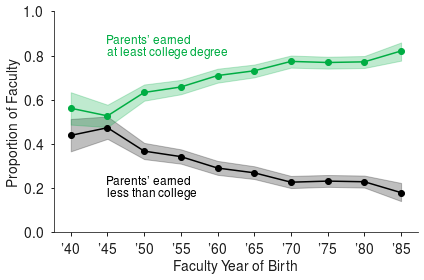

In [11]:
fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)
years = [1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985]

elem = np.array([total_data[i].get('Elementary: 0-8 years', 0) for i in range(len(total_data))])
less_hs = np.array([total_data[i].get('High school: 1-3 years', 0) for i in range(len(total_data))])
hs = np.array([(total_data[i]['High school: 4 years']) for i in range(len(total_data))])
less_college = np.array([(total_data[i]['College: 1-3 years']) for i in range(len(total_data))])
college = np.array([(total_data[i]['College: 4+ years']) for i in range(len(total_data))])
masters = np.array([(total_data[i]["Master's or professional degree"]) for i in range(len(total_data))])
phd = np.array([(total_data[i]['Doctoral degree']) for i in range(len(total_data))])

ax.set_ylim(0.0, 1.0)
ax.plot(years, elem + less_hs + hs + less_college, label = "Parents' earned\nless than college", 
        color = 'black', marker="o")
lower, upper = zip(*cis_less_than)
ax.fill_between(years, lower, upper, alpha=0.25, color = 'black')

ax.plot(years, college + masters + phd, label = "Parents' earned\nat least college degree",
        color = plot_utils.ACCENT_COLOR, marker="o")
lower, upper = zip(*cis_more_than)
ax.fill_between(years, lower, upper, alpha=0.25, color = plot_utils.ACCENT_COLOR)

ax.set_ylabel('Proportion of Faculty')
ax.set_xlabel('Faculty Year of Birth')
ax.set_xticks(years)
ax.set_xticklabels(["'%d" % (y - 1900) for y in years], fontsize=plot_utils.LEGEND_SIZE)
#plt.legend(frameon=False, loc=(1,0.5))

ax.text(1945, 0.16, "Parents' earned\nless than college", fontsize=plot_utils.LEGEND_SIZE, 
        color='black')
ax.text(1945, 0.80, "Parents' earned\nat least college degree", fontsize=plot_utils.LEGEND_SIZE, 
        color=plot_utils.ACCENT_COLOR)

plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/education_breakdown_generation.pdf', dpi=1000)

In [12]:
# Has the percentage of faculty with PhD parents been increasing over time?
# data = pd.DataFrame([{'age_coded': year, 
#                      'parents_had_phd': edu_dist['Doctoral degree']} 
#                     for (year, edu_dist) in zip(years, total_data)])
data = respondents_zip.copy(deep=True)[['parents_had_phd', 'age_coded']].dropna()
# data = respondents_zip.groupby(['age_coded'])['parents_had_phd'].mean().reset_index())

mod = sm.Logit(data['parents_had_phd'], sm.add_constant(data['age_coded']))        
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.528025
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        parents_had_phd   No. Observations:                 7184
Model:                          Logit   Df Residuals:                     7182
Method:                           MLE   Df Model:                            1
Date:                Tue, 07 Jun 2022   Pseudo R-squ.:                0.004012
Time:                        10:26:36   Log-Likelihood:                -3793.3
converged:                       True   LL-Null:                       -3808.6
Covariance Type:            nonrobust   LLR p-value:                 3.240e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.6987      4.638     -5.757      0.000     -35.788     -17.609
age_coded      0.0129      0.002      5.489      0.000       0.008       0.018
==============================================================================
"""

### Differences by discipline

In [13]:
discs = respondents_zip.likely_department.dropna().unique()
for i, disc in enumerate(discs):
    discipline_data = respondents_zip[respondents_zip.likely_department == disc].copy(deep=True)
    discipline_dist = dict(discipline_data['parents_highest_edu_coded'].value_counts(normalize=True).sort_index())
    print('\n>>> ' + disc, 
          #discipline_dist, '\n',
          '\nLess than college:\t', sum([discipline_dist['College: 1-3 years'],
                                         discipline_dist['High school: 4 years'],
                                         discipline_dist['High school: 1-3 years'], 
                                         discipline_dist['Elementary: 0-8 years']]),
          '\nCollege:\t\t', discipline_dist["College: 4+ years"], 
          '\nMore than college:\t', sum([discipline_dist["Master's or professional degree"], 
               discipline_dist["Doctoral degree"]]))
    


>>> Business 
Less than college:	 0.2841691248770895 
College:		 0.24090462143559488 
More than college:	 0.47492625368731567

>>> History 
Less than college:	 0.21937639198218264 
College:		 0.17037861915367483 
More than college:	 0.6102449888641426

>>> Computer Science 
Less than college:	 0.263 
College:		 0.216 
More than college:	 0.521

>>> Anthropology 
Less than college:	 0.2535211267605634 
College:		 0.19436619718309858 
More than college:	 0.5521126760563381

>>> Physics and/or Astronomy 
Less than college:	 0.3037433155080214 
College:		 0.18288770053475936 
More than college:	 0.5133689839572192

>>> Psychology 
Less than college:	 0.3105209397344229 
College:		 0.17058222676200205 
More than college:	 0.5188968335035751

>>> Sociology 
Less than college:	 0.28859060402684567 
College:		 0.17002237136465326 
More than college:	 0.5413870246085011

>>> Biology 
Less than college:	 0.3243068987749839 
College:		 0.1947130883301096 
More than college:	 0.4809800128949065


In [14]:
# Individuals across all years
alpha = 0.2
temp = respondents_zip[~respondents_zip.rank_scaled.isna() & ~respondents_zip.likely_department.isna()]
field_pi = temp.groupby('likely_department').rank_scaled.quantile(alpha)

top_pi = temp.likely_department.apply(lambda x: field_pi[x])
top_pedu_dist = temp[temp.rank_scaled < top_pi].parents_had_phd.dropna().astype(float)

field_pi = temp.groupby('likely_department').rank_scaled.quantile(1-alpha)
bottom_pi = temp.likely_department.apply(lambda x: field_pi[x])
bottom_pedu_dist = temp[temp.rank_scaled >= bottom_pi].parents_had_phd.dropna().astype(float)

print(top_pedu_dist.mean(), bottom_pedu_dist.mean(), 
      (top_pedu_dist.mean()-bottom_pedu_dist.mean())/bottom_pedu_dist.mean())
print([sum(top_pedu_dist.isin([0, 1])), sum(bottom_pedu_dist.isin([0, 1]))])
print(proportions_ztest([sum(top_pedu_dist > 0), sum(bottom_pedu_dist > 0)], 
                        [sum(top_pedu_dist.isin([0, 1])), len(bottom_pedu_dist.isin([0, 1]))]))
print(confint_proportions_2indep(sum(top_pedu_dist > 0), sum(top_pedu_dist.isin([0, 1])),
                                 sum(bottom_pedu_dist > 0), len(bottom_pedu_dist.isin([0, 1]))))

0.29840737636211234 0.18957011980267793 0.5741266433376856
[1193, 1419]
(6.494364345948152, 8.338472532815575e-11)
(0.07582791483492338, 0.14182808304151479)


### Trends in percentage PhD parents by current prestige

Among faculty at the top 20% and bottom 20% of institutions by ranking, what proportion had PhDs.

In [15]:
phd_parents_by_prestige = pd.DataFrame()
temp = respondents_zip[~respondents_zip.rank_scaled.isna() & ~respondents_zip.likely_department.isna() &
                       ~respondents_zip.parents_had_phd.isna()]
# field_pi = temp.groupby('likely_department').rank_scaled.quantile(alpha)
# top_pi = temp.likely_department.apply(lambda x: field_pi[x])
top_pi = temp.rank_scaled.quantile(alpha)
top_pedu_dist = temp[temp.rank_scaled < top_pi]

print(top_pedu_dist.shape[0], dict(top_pedu_dist.likely_department.value_counts()))

top_20_data = []; top_cis = []
year_couples = [(1940, 1950), (1950, 1960), (1960, 1970), (1970, 1980), (1980, 1990)]
for year_start, year_end in year_couples:
    parents_had_phd = top_pedu_dist[(top_pedu_dist.age_coded >= year_start) & \
                                    (top_pedu_dist.age_coded < year_end)].parents_had_phd.astype(float)
    print(year_start, dict(parents_had_phd.value_counts()))
    
    n = len(parents_had_phd)
    phd_parents_by_prestige = phd_parents_by_prestige.append([
        {'year bin': x, 'prestige rank': y, 'phd parent': z} for x, y, z in zip(
            n*[year_start], n*['top 20'], parents_had_phd.values)], 
        ignore_index=True)
    top_20_data.append(sum(parents_had_phd == 1)/len(parents_had_phd))
    top_cis.append(binomial_confidence_interval(parents_had_phd))

1298 {'Biology': 330, 'Computer Science': 228, 'Physics and/or Astronomy': 184, 'Psychology': 160, 'Business': 136, 'History': 132, 'Sociology': 77, 'Anthropology': 51}
1940 {0.0: 101, 1.0: 25}
1950 {0.0: 215, 1.0: 71}
1960 {0.0: 171, 1.0: 94}
1970 {0.0: 234, 1.0: 115}
1980 {0.0: 163, 1.0: 78}


In [16]:
temp = respondents_zip[~respondents_zip.rank_scaled.isna() & ~respondents_zip.likely_department.isna() &
                       ~respondents_zip.parents_had_phd.isna()]
# field_pi = temp.groupby('likely_department').rank_scaled.quantile(1-alpha)
# bot_pi = temp.likely_department.apply(lambda x: field_pi[x])
bot_pi = temp.rank_scaled.quantile(1-alpha)
bot_pedu_dist = temp[temp.rank_scaled >= bot_pi]

print(bot_pedu_dist.shape[0], dict(bot_pedu_dist.likely_department.value_counts()))

bottom_80_data = []; bottom_cis = []
for year_start, year_end in year_couples:
    parents_had_phd = bot_pedu_dist[(bot_pedu_dist.age_coded >= year_start) & \
                                    (bot_pedu_dist.age_coded < year_end)].parents_had_phd.astype(float)
    print(year_start, dict(parents_had_phd.value_counts()))
    
    phd_parents_by_prestige = phd_parents_by_prestige.append(
        [{'year bin': x, 'prestige rank': y, 'phd parent': z} for x, y, z in zip(
            n*[year_start], n*['bottom 80'], parents_had_phd.values)], 
        ignore_index=True)
    bottom_80_data.append(sum(parents_had_phd == 1)/len(parents_had_phd))
    bottom_cis.append(binomial_confidence_interval(parents_had_phd))

1330 {'History': 229, 'Business': 227, 'Biology': 221, 'Psychology': 193, 'Computer Science': 180, 'Physics and/or Astronomy': 150, 'Sociology': 65, 'Anthropology': 65}
1940 {0.0: 79, 1.0: 7}
1950 {0.0: 222, 1.0: 44}
1960 {0.0: 272, 1.0: 64}
1970 {0.0: 297, 1.0: 71}
1980 {0.0: 209, 1.0: 49}


In [17]:
overall_avg_data = [] # Average over time
for year_start, year_end in year_couples:
    born_in_year = respondents_zip[(respondents_zip.age_coded >= year_start) & \
                                   (respondents_zip.age_coded < year_end)].copy()
    overall_avg_data.append(born_in_year['parents_highest_edu_coded'].value_counts(normalize=True))

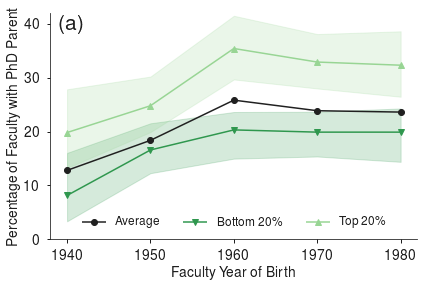

In [18]:
fig, ax = plt.subplots()

category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 3))[::-1]
ax.set_ylim(0, 45)
# years = np.array([1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985])
years = np.array([1940, 1950, 1960, 1970, 1980])    
ax.plot(years, [each['Doctoral degree']*100 for each in overall_avg_data], label = 'Average', 
        color=plot_utils.ALMOST_BLACK, marker='o', alpha=1, zorder=1)
               
aggregated = phd_parents_by_prestige.groupby(['prestige rank', 'year bin']).mean().reset_index()
ax.plot(years, aggregated[aggregated['prestige rank'] == 'bottom 80']['phd parent']*100, linestyle='-',
        label = 'Bottom {:1.0f}\%'.format(alpha*100), color=category_colors[1], alpha=1, 
        marker='v', zorder=2)
lower, upper = zip(*bottom_cis)
ax.fill_between(years, np.array(lower)*100, np.array(upper)*100, alpha=0.2, color=category_colors[1])

# lower, upper = zip(*cis)
# ax.fill_between(years, lower, upper, alpha=0.25, color = 'black')
# print(cis)
ax.text(1939, 39, '(a)', size=1.5*plot_utils.LABEL_SIZE)

ax.plot(years, aggregated[aggregated['prestige rank'] == 'top 20']['phd parent']*100, linestyle='-',
        label = 'Top {:1.0f}\%'.format(alpha*100), color=category_colors[2], alpha=1, marker='^', 
        zorder=2)
lower, upper = zip(*top_cis)
ax.fill_between(years, np.array(lower)*100, np.array(upper)*100, alpha=0.2, color=category_colors[2])

ax.set_ylabel('Percentage of Faculty with PhD Parent', size=plot_utils.LABEL_SIZE)
ax.set_xlabel('Faculty Year of Birth', size=plot_utils.LABEL_SIZE)
plt.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE, ncol=3, loc='lower center')

plot_utils.finalize(ax)
plt.tight_layout()
plt.ylim(0, 42)
plt.savefig('../plots/education_generation.pdf', dpi=1000)

In [19]:
[each['Doctoral degree']*100 for each in overall_avg_data]

[12.802768166089965,
 18.38856400259909,
 25.86696986924389,
 23.901673640167363,
 23.64607170099161]

Aggregated across all years, is this difference in proportions of PhD parents statistically different?

In [20]:
# Aggregated to the years
ttest_ind(bottom_80_data, top_20_data, equal_var=False)

Ttest_indResult(statistic=-3.5160158599217315, pvalue=0.009109328552748612)

Another way of viewing the above relationship is by plotting percentage of PhD parents versus current institutional prestige.

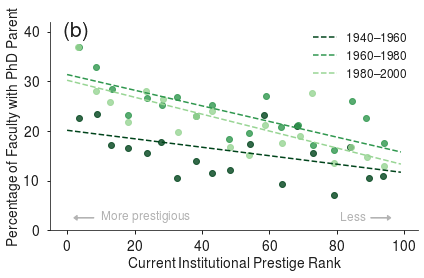

In [21]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)
prestige_range = range(0, 100)
prestige_bins = range(1, 101, 5)

category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 3))[::-1]
models = []
# category_colors = [plot_utils.ALMOST_BLACK, plot_utils.ACCENT_COLOR, plot_utils.ACCENT_COLOR]
for i, (year_start, year_end) in enumerate([(1940, 1960), (1960, 1980), (1980, 2000)]):
    temp = respondents_zip[~respondents_zip.parents_had_phd.isna()]
    temp = temp[(temp.age_coded >= year_start) & (temp.age_coded < year_end)]
    # print(1/temp['rank_scaled'])
    
    res = smf.ols('parents_had_phd ~ rank_scaled', data=temp).fit()
    models.append(res)
    ax.plot(prestige_range, [100.*(res.params['Intercept']+res.params['rank_scaled']*pi) for pi in prestige_range], 
            label='%.0f--%.0f' % (year_start, year_end), color=category_colors[i], linestyle='dashed')
    
    # print(len(temp), temp.groupby(pd.cut(temp.rank_scaled, prestige_bins)).size())
    temp = temp.groupby(pd.cut(temp.rank_scaled, prestige_bins))[['rank_scaled', 'parents_had_phd']].mean()
    ax.scatter(temp.rank_scaled, temp.parents_had_phd*100., alpha=0.8, color=category_colors[i])
    
shift = 2
ax.arrow(8, 1.25*shift, -5, 0, head_width=shift/2, head_length=1, color=plot_utils.LIGHT_COLOR)
ax.text(10, shift, 'More prestigious', fontsize=plot_utils.LEGEND_SIZE, color=plot_utils.LIGHT_COLOR)
ax.arrow(90, 1.25*shift, 5, 0, head_width=shift/2, head_length=1, color=plot_utils.LIGHT_COLOR)
ax.text(81, shift, 'Less', fontsize=plot_utils.LEGEND_SIZE, color=plot_utils.LIGHT_COLOR)

ax.text(-1, 39, '(b)', size=1.5*plot_utils.LABEL_SIZE)

ax.set_ylabel('Percentage of Faculty with PhD Parent', size=plot_utils.LABEL_SIZE)
ax.set_xlabel('Current Institutional Prestige Rank', size=plot_utils.LABEL_SIZE)

plt.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE)
plot_utils.finalize(ax)
plt.tight_layout()
plt.ylim(0, 42)
plt.savefig('../plots/phd_parents_prestige.pdf', dpi=500)

These differences in slope over time aren't significantly different, but the intercepts are. Regression lines above are just meant for visualization purposes.

In [22]:
temp = respondents_zip[~respondents_zip.parents_had_phd.isna()].copy()

temp.loc['birth_cohort'] = np.nan
temp.loc[((temp.age_coded >= 1940) & (temp.age_coded < 1960)),'birth_cohort'] = '1940-60'
temp.loc[((temp.age_coded >= 1960) & (temp.age_coded < 1980)),'birth_cohort'] = '1960-80'
temp.loc[((temp.age_coded >= 1980) & (temp.age_coded < 2000)),'birth_cohort'] = '1980-00'

res = smf.ols('parents_had_phd ~ 1 + rank_scaled*C(birth_cohort)', data=temp).fit()
print(res.summary())

# Returns a t-statistic, p-value, & CI for the difference
print(res.t_test("rank_scaled = rank_scaled:C(birth_cohort)[T.1980-00]"))

                            OLS Regression Results                            
Dep. Variable:        parents_had_phd   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     21.12
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           5.18e-21
Time:                        10:26:39   Log-Likelihood:                -3476.3
No. Observations:                6459   AIC:                             6965.
Df Residuals:                    6453   BIC:                             7005.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### College completion among faculty parents relative to general US

In [23]:
college_label = 'College: 4+ years'; masters_label = "Master's or professional degree"
print([college_label, masters_label, doctoral_label])
college_plus_labels = [college_label, masters_label, doctoral_label]

['College: 4+ years', "Master's or professional degree", 'Doctoral degree']


In [24]:
# From '../data/us_census_edu/census/tabn104.10.xls' 
#  (https://nces.ed.gov/programs/digest/d19/tables/dt19_104.10.asp)
census_college_completion = pd.DataFrame({
    'Year': [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1975, 1980, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 
              1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 
              2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    "Bachelor's or higher degree" : [2.7, 3.3, 3.9, 4.6, 6.2, 7.7, 11.0, 13.9, 17.0, 19.4, 19.4, 19.9, 20.3, 
                                     21.1, 21.3, 21.4, 21.4, 21.9, 22.2, 23.0, 23.6, 23.9, 24.4, 25.2, 25.6, 
                                     26.1, 26.7, 27.2, 27.7, 27.7, 28.0, 28.7, 29.4, 29.5, 29.9, 30.4, 30.9, 
                                     31.7, 32.0, 32.5, 33.4, 34.2, 35.0, 36.0]})
census_college_completion["Bachelor's or higher degree"] = census_college_completion["Bachelor's or higher degree"] / 100.0

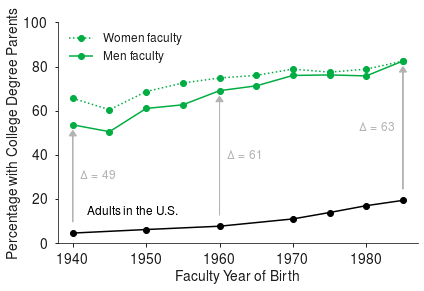

In [25]:
category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 3))[::-1]
fig, ax = plt.subplots(1, 1, figsize = plot_utils.SINGLE_FIG_SIZE)

ax.set_ylim(0, 100)
ax.set_xlim(1938, 1987)

gender_id = (respondents_zip.gender_ans == 'Female')
not_first_gen = respondents_zip[gender_id & respondents_zip.parents_highest_edu_coded.isin(
        college_plus_labels)].age_coded.dropna()
first_gen = respondents_zip[gender_id & ~respondents_zip.parents_highest_edu_coded.isin(
    college_plus_labels)].age_coded.dropna()

data = []
years = [(1940, 1945), (1945, 1950), (1950, 1955), (1955, 1960), (1960, 1965), (1965, 1970), (1970, 1975), 
         (1975, 1980), (1980, 1985), (1985, 1990)]
for year_start, year_end in years:
    count_not_first_gen = sum(((np.array(not_first_gen) >= year_start) & (np.array(not_first_gen) < year_end)))
    count_first_gen = sum(((np.array(first_gen) >= year_start) & (np.array(first_gen) < year_end)))
    # print(count_not_first_gen, count_first_gen)
    data.append(count_not_first_gen/(count_not_first_gen + count_first_gen))
data_all = pd.DataFrame({'year': [y[0] for y in years], 'data': data})
data_all = data_all.set_index('year')
ax.plot([y[0] for y in years], np.array(data)*100., label='Women faculty', color=plot_utils.ACCENT_COLOR, 
       marker='o', linestyle=':')

gender_id = (respondents_zip.gender_ans == 'Male')
not_first_gen = respondents_zip[gender_id & respondents_zip.parents_highest_edu_coded.isin(
        college_plus_labels)].age_coded.dropna()
first_gen = respondents_zip[gender_id & ~respondents_zip.parents_highest_edu_coded.isin(
    college_plus_labels)].age_coded.dropna()

data = []
for year_start, year_end in years:
    count_not_first_gen = sum(((np.array(not_first_gen) >= year_start) & (np.array(not_first_gen) < year_end)))
    count_first_gen = sum(((np.array(first_gen) >= year_start) & (np.array(first_gen) < year_end)))
    # print(count_not_first_gen, count_first_gen)
    data.append(count_not_first_gen/(count_not_first_gen + count_first_gen))
data_all = pd.DataFrame({'year': [y[0] for y in years], 'data': data})
data_all = data_all.set_index('year')
ax.plot([y[0] for y in years], np.array(data)*100., label='Men faculty', color=plot_utils.ACCENT_COLOR, 
       marker='o')

subset_years = [1940, 1950, 1960, 1970, 1975, 1980, 1985]
subset_data = list(census_college_completion[census_college_completion['Year'].isin(subset_years)]["Bachelor's or higher degree"].values)
subset_data_all = pd.DataFrame({'year': subset_years, 'data': subset_data})
subset_data_all = subset_data_all.set_index('year')

ax.plot(subset_years, np.array(subset_data)*100., color='black', marker='o')
ax.set_ylabel('Percentage with College Degree Parents')
ax.set_xlabel('Faculty Year of Birth')

ax.text(1942, 13., "Adults in the U.S.", fontsize=plot_utils.LEGEND_SIZE, 
        color='black')
# ax.text(1970, 85.5, "Parents of Male Faculty", fontsize=plot_utils.LEGEND_SIZE, 
#        color=plot_utils.ACCENT_COLOR)
plt.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE)

delta = 5; T = 1940; diff = (100.*data_all.loc[T, 'data'] - 100.*subset_data_all.loc[T, 'data'])
ax.arrow(T, 100*subset_data_all.loc[T, 'data'] + delta, 0, diff - 2*delta, head_width=delta/5, 
         head_length=delta/2, color=plot_utils.LIGHT_COLOR)
ax.text(T+1, 100*subset_data_all.loc[T, 'data'] + diff/2, r'$\Delta = %.0f$' % diff, 
        fontsize=plot_utils.LEGEND_SIZE, color=plot_utils.LIGHT_COLOR)

T = 1960; diff = (100*data_all.loc[T, 'data'] - 100*subset_data_all.loc[T, 'data'])
ax.arrow(T, 100*subset_data_all.loc[T, 'data'] + delta, 0, diff - 2*delta, head_width=delta/5, 
         head_length=delta/2, color=plot_utils.LIGHT_COLOR)
ax.text(T+1, 100*subset_data_all.loc[T, 'data'] + diff/2, r'$\Delta = %.0f$' % diff, 
        fontsize=plot_utils.LEGEND_SIZE, color=plot_utils.LIGHT_COLOR)

T = 1985; diff = (100*data_all.loc[T, 'data'] - 100*subset_data_all.loc[T, 'data'])
ax.arrow(T, 100*subset_data_all.loc[T, 'data'] + delta, 0, diff - 2*delta, head_width=delta/5, 
         head_length=delta/2, color=plot_utils.LIGHT_COLOR)
ax.text(T-6, 100*subset_data_all.loc[T, 'data'] + diff/2, r'$\Delta = %.0f$' % diff, 
        fontsize=plot_utils.LEGEND_SIZE, color=plot_utils.LIGHT_COLOR)

plot_utils.finalize(ax)

plt.tight_layout()
plt.savefig('../plots/education_generation_college.pdf', dpi=1000)

Above, there is an interesting relationship with gender: women come from more highly educated families than men.

1st Gen	 2566
Not	 4676
MannwhitneyuResult(statistic=5419553.5, pvalue=4.787877262554441e-12)


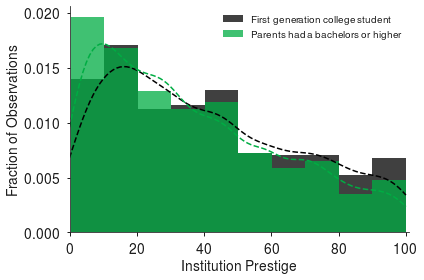

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=plot_utils.SINGLE_FIG_SIZE)
prestige_range = np.arange(0, 101); 

first_gen = respondents_zip[~respondents_zip.parents_highest_edu_coded.isin(
    college_plus_labels)].rank_scaled.dropna()
print('1st Gen\t', len(first_gen))
plt.hist(first_gen, color='black', density=True, 
         label = 'First generation college student', alpha=0.75)
plt.plot(prestige_range, sps.gaussian_kde(first_gen).pdf(prestige_range), 
         label=None, color='black', linestyle='--')

not_first_gen = respondents_zip[respondents_zip.parents_highest_edu_coded.isin(
    college_plus_labels)].rank_scaled.dropna()
print('Not\t', len(not_first_gen))
plt.hist(not_first_gen, color=plot_utils.ACCENT_COLOR, density=True, 
         label = 'Parents had a bachelors or higher', alpha=0.75)
plt.plot(prestige_range, sps.gaussian_kde(not_first_gen).pdf(prestige_range), 
         label=None, color=plot_utils.ACCENT_COLOR, linestyle='--')

plt.xlabel('Institution Prestige', size=plot_utils.LABEL_SIZE)
plt.ylabel('Fraction of Observations', size=plot_utils.LABEL_SIZE)
plt.legend(frameon=False)

print(mannwhitneyu(first_gen, not_first_gen))

plt.xlim(0, 101)
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/prestige_p1p2_college.pdf', dpi=1000)

### Relationship between parents' education level and family support

In [27]:
# 1 (none at all) to 5 (a lot)
respondents_zip.groupby(['parents_highest_edu_coded'])['support_parents'].describe() 

,count,mean,std,min,25%,50%,75%,max
parents_highest_edu_coded,,,,,,,,
College: 1-3 years,546.0,3.858974,1.235663,1.0,3.0,4.0,5.0,5.0
College: 4+ years,1099.0,3.907188,1.206590,1.0,3.0,4.0,5.0,5.0
Doctoral degree,1269.0,4.457053,0.953538,1.0,4.0,5.0,5.0,5.0
Elementary: 0-8 years,127.0,3.559055,1.525724,1.0,2.0,4.0,5.0,5.0
High school: 1-3 years,150.0,3.700000,1.304355,1.0,3.0,4.0,5.0,5.0
High school: 4 years,797.0,3.500627,1.371483,1.0,2.0,4.0,5.0,5.0
Master's or professional degree,1737.0,4.124352,1.098055,1.0,4.0,5.0,5.0,5.0


In [28]:
# How important is for women to have highly educated mothers vs. fathers? I'd suspect mother role model will 
# be important for women in particular; although of course a highly educated mother is also a good role 
# model for men. In particular, I wonder if women get more support (Fig 2) if mother has PhD as opposed to 
# 'only' father, as opposed to neither parent.
support_id = 'support_parents'

print(respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                      (respondents_zip.mom_edu_coded == 'Doctoral degree')][support_id].mean())
print(respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                (respondents_zip.mom_edu_coded != 'Doctoral degree') &
                (respondents_zip.dad_edu_coded == 'Doctoral degree')][support_id].mean())
print(respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                (respondents_zip.mom_edu_coded != 'Doctoral degree') &
                (respondents_zip.dad_edu_coded != 'Doctoral degree')][support_id].mean())

print(ttest_ind(respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                                (respondents_zip.mom_edu_coded == 'Doctoral degree')][support_id].dropna(),
                respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                                (respondents_zip.mom_edu_coded != 'Doctoral degree') &
                                (respondents_zip.dad_edu_coded == 'Doctoral degree')][support_id].dropna(), 
                equal_var=False))

print(ttest_ind(respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                                (respondents_zip.mom_edu_coded == 'Doctoral degree')][support_id].dropna(),
                respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                                (respondents_zip.mom_edu_coded != 'Doctoral degree') &
                                (respondents_zip.dad_edu_coded != 'Doctoral degree')][support_id].dropna(), 
                equal_var=False))

print(ttest_ind(respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                                (respondents_zip.mom_edu_coded != 'Doctoral degree') &
                                (respondents_zip.dad_edu_coded == 'Doctoral degree')][support_id].dropna(),
                respondents_zip[(respondents_zip.gender_ans == 'Female') & 
                                (respondents_zip.mom_edu_coded != 'Doctoral degree') &
                                (respondents_zip.dad_edu_coded != 'Doctoral degree')][support_id].dropna(), 
                equal_var=False))

4.512345679012346
4.441860465116279
3.869952494061758
Ttest_indResult(statistic=0.8143565455968488, pvalue=0.41607357583995264)
Ttest_indResult(statistic=8.191427761452855, pvalue=2.0411347098346644e-14)
Ttest_indResult(statistic=10.147363636756872, pvalue=9.847524405240188e-23)


Average support level by faculty gender is very similar! Remains true when you stratify by parents' education.

In [29]:
respondents_zip.groupby('gender_ans')['support_parents'].mean()

gender_ans
Female               4.015674
Male                 4.022819
Other identity       3.583333
Prefer not to say    4.291667
Name: support_parents, dtype: float64

In [30]:
women_support = respondents_zip[respondents_zip.gender_ans == 'Female']['support_parents'].dropna()
men_support = respondents_zip[respondents_zip.gender_ans == 'Male']['support_parents'].dropna()

print(len(women_support) + len(men_support), np.mean(women_support), np.mean(men_support))
print(ttest_ind(women_support, men_support, equal_var=False))

r = sms.CompareMeans(sms.DescrStatsW(women_support), sms.DescrStatsW(men_support))
print(r.tconfint_diff(usevar='unequal'))

5695 4.015673981191223 4.022819179664934
Ttest_indResult(statistic=-0.21904551911132325, pvalue=0.8266239674904428)
(-0.0710948675505663, 0.056804470603144794)


In [31]:
respondents_zip[(respondents_zip.mom_edu_coded == 'Doctoral degree')].groupby('gender_ans')['support_parents'].mean()

gender_ans
Female               4.512346
Male                 4.492147
Prefer not to say         NaN
Name: support_parents, dtype: float64

In [32]:
respondents_zip['support_parents'].mean()

4.020240795672658

In [33]:
women_mom_edu_dist = respondents_zip[respondents_zip.gender_ans == 'Female']['mom_edu_coded'].dropna().isin(
    ["Master's or professional degree", 'Doctoral degree'])
print(women_mom_edu_dist.value_counts(normalize=True))

men_mom_edu_dist = respondents_zip[respondents_zip.gender_ans == 'Male']['mom_edu_coded'].dropna().isin(
    ["Master's or professional degree", 'Doctoral degree'])
print(men_mom_edu_dist.value_counts(normalize=True))

print(len(women_mom_edu_dist) + len(men_mom_edu_dist))
print(proportions_ztest([sum(women_mom_edu_dist), sum(men_mom_edu_dist)], 
                        [len(women_mom_edu_dist), len(men_mom_edu_dist)]))
print(confint_proportions_2indep(sum(women_mom_edu_dist), len(women_mom_edu_dist),
                                 sum(men_mom_edu_dist), len(men_mom_edu_dist)))

False    0.667051
True     0.332949
Name: mom_edu_coded, dtype: float64
False    0.717488
True     0.282512
Name: mom_edu_coded, dtype: float64
7107
(4.465386547664603, 7.992431690107795e-06)
(0.028158207131478718, 0.07289611760573596)


In [34]:
respondents_zip['parents_highest_edu_coded'].dropna().isin(
    ["Master's or professional degree", 'Doctoral degree']).value_counts(normalize=True)

True     0.518519
False    0.481481
Name: parents_highest_edu_coded, dtype: float64

In [35]:
((respondents_zip.p1_edu_coded == 'Doctoral degree') &  
 (respondents_zip.p2_edu_coded == 'Doctoral degree')).value_counts(normalize=True) # Have two PhD parents

False    0.963291
True     0.036709
dtype: float64

1: None
2
3
4
5: A lot


<ipython-input-36-8345fa79a2a1>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=labels, fontsize=plot_utils.LEGEND_SIZE)


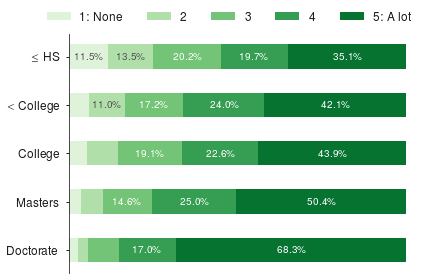

In [36]:
category_names = ['1: None', '2', '3', '4', '5: A lot']
# https://matplotlib.org/3.1.3/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html
gender_id = True # (respondents_zip.gender_ans == 'Female')
parent_col = 'parents_highest_edu_coded' #'dad_edu_coded'
support_col = 'support_parents'

results = {
    r'$\leq$ HS': respondents_zip[gender_id & (respondents_zip[parent_col].isin(['Elementary: 0-8 years', 
    'High school: 1-3 years', 'High school: 4 years']))][support_col].value_counts(normalize=True).sort_index().values,
    r'$<$ College': respondents_zip[gender_id & (respondents_zip[parent_col] == 'College: 1-3 years')][support_col].value_counts(normalize=True).sort_index().values,
    'College': respondents_zip[gender_id & (respondents_zip[parent_col] == 'College: 4+ years')][support_col].value_counts(normalize=True).sort_index().values,
    'Masters': respondents_zip[gender_id & (respondents_zip[parent_col] == "Master's or professional degree")][support_col].value_counts(normalize=True).sort_index().values,
    'Doctorate': respondents_zip[gender_id & (respondents_zip[parent_col] == 'Doctoral degree')][support_col].value_counts(normalize=True).sort_index().values,
}

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.get_cmap('Greens')(np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    print(colname)
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
    xcenters = starts + widths / 2

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.25 else '0.325'
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        if c > 0.1:
            ax.text(x, y, r'{:1.1f}\%'.format(c*100.0), ha='center', va='center', color=text_color)
        ax.legend(ncol=len(category_names), bbox_to_anchor=(-0.1, 1), loc='lower left', 
                  fontsize=plot_utils.LEGEND_SIZE, frameon=False)
        
# plt.title("Support from Family by Parents' Highest Education", fontsize=plot_utils.TITLE_SIZE, pad=32)
# ax.set_ylabel("Parents' Highest Degree", fontsize=plot_utils.TITLE_SIZE)

plot_utils.finalize(ax)
ax.get_xaxis().tick_bottom()
ax.set_yticklabels(labels=labels, fontsize=plot_utils.LEGEND_SIZE)
ax.spines["bottom"].set_visible(False)
plt.tight_layout()

plt.savefig('../plots/parent_support.pdf', dpi=500)

In [37]:
# Does not include CS responses, which are coded differently 
doctoral_label = 'Doctoral degree'
temp = respondents_zip[~respondents_zip['parents_highest_edu_coded'].isna()]
not_first_gen_doctorate = temp[(temp['parents_highest_edu_coded'] == doctoral_label)]['support_parents'].dropna()
first_gen_doctorate = temp[temp['parents_highest_edu_coded'] != doctoral_label]['support_parents'].dropna()

print(dict(pd.Series(not_first_gen_doctorate).value_counts()), 
      dict(pd.Series(first_gen_doctorate).value_counts()))

{5.0: 867, 4.0: 216, 3.0: 116, 2.0: 39, 1.0: 31} {5.0: 1965, 4.0: 1025, 3.0: 774, 2.0: 423, 1.0: 269}


In [38]:
not_first_gen_doctorate = not_first_gen_doctorate[~pd.isnull(not_first_gen_doctorate)]
first_gen_doctorate = first_gen_doctorate[~pd.isnull(first_gen_doctorate)]

Are these differences between PhD parents and not significant? Yes, (a) by testing the proportions who report less than / greater than 3, and (b) by the distributions of responses [1, 2, 3, 4, 5], and (c) by a t-test for a difference in their mean support values.

In [39]:
print(np.count_nonzero(not_first_gen_doctorate > 3.0), np.count_nonzero(first_gen_doctorate > 3.0))
print(np.count_nonzero(not_first_gen_doctorate > 3.0)/len(not_first_gen_doctorate), 
      np.count_nonzero(first_gen_doctorate > 3.0)/len(first_gen_doctorate))
# print(proportions_ztest([np.count_nonzero(not_first_gen_doctorate > 3.0), 
#                          np.count_nonzero(first_gen_doctorate > 3.0)],
#                         [len(not_first_gen_doctorate), len(first_gen_doctorate)])) # Should be same as chi^2

1083 2990
0.8534278959810875 0.6710053859964094


In [40]:
chi2_contingency([[np.count_nonzero(not_first_gen_doctorate > 3.0), 
                   np.count_nonzero(not_first_gen_doctorate <= 3.0)], 
                  [np.count_nonzero(first_gen_doctorate > 3.0), 
                   np.count_nonzero(first_gen_doctorate <= 3.0)]], correction=False)

(160.10861330858492,
 1.0713162337825576e-36,
 1,
 array([[ 902.81868996,  366.18131004],
        [3170.18131004, 1285.81868996]]))

In [41]:
not_first_gen_doctorate.value_counts().sort_index().values

array([ 31,  39, 116, 216, 867])

In [42]:
chi2_contingency([[not_first_gen_doctorate.value_counts().sort_index().values], 
                  [first_gen_doctorate.value_counts().sort_index().values]], correction=False)

(251.27311644145547,
 3.4617455133817216e-53,
 4,
 array([[[  66.49781659,  102.40663755,  197.2768559 ,  275.07930131,
           627.73938865]],
 
        [[ 233.50218341,  359.59336245,  692.7231441 ,  965.92069869,
          2204.26061135]]]))

Faculty who had a parent with a PhD reported receiving more parental support for their academic career then faculty whose parents did not earn a PhD.

In [43]:
print(len(not_first_gen_doctorate) + len(first_gen_doctorate), 
      np.mean(not_first_gen_doctorate), np.mean(first_gen_doctorate))
print(ttest_ind(not_first_gen_doctorate, first_gen_doctorate, equal_var=False))

r = sms.CompareMeans(sms.DescrStatsW(not_first_gen_doctorate), sms.DescrStatsW(first_gen_doctorate))
print(r.tconfint_diff(usevar='unequal'))

5725 4.45705279747833 3.8963195691202874
Ttest_indResult(statistic=17.22890388282989, pvalue=4.465110027133807e-63)
(0.4969144021202891, 0.6245520545957952)


### Importance of geography and career age by parents' education

In [44]:
# Responses with '4'-->'not applicable'
not_first_gen_doctorate = respondents_zip[respondents_zip['parents_highest_edu_coded'] == doctoral_label]['current_geo'].dropna()
first_gen_doctorate = respondents_zip[respondents_zip['parents_highest_edu_coded'] != doctoral_label]['current_geo'].dropna()

print(dict(pd.Series(not_first_gen_doctorate).value_counts()), 
      dict(pd.Series(first_gen_doctorate).value_counts()))

{3.0: 722, 2.0: 510, 1.0: 204} {3.0: 2389, 2.0: 1823, 1.0: 747}


In [45]:
not_first_gen_doctorate = not_first_gen_doctorate[~pd.isnull(not_first_gen_doctorate)]
first_gen_doctorate = first_gen_doctorate[~pd.isnull(first_gen_doctorate)]

In [46]:
print(np.count_nonzero(not_first_gen_doctorate > 2.0), np.count_nonzero(first_gen_doctorate > 2.0))
print(np.count_nonzero(not_first_gen_doctorate > 2.0)/len(not_first_gen_doctorate), 
      np.count_nonzero(first_gen_doctorate > 2.0)/len(first_gen_doctorate))

722 2389
0.5027855153203342 0.4817503528937286


No significant relationship between how important geography was in choosing a position for those with / without PhD parents.

In [47]:
print(np.mean(not_first_gen_doctorate), np.mean(first_gen_doctorate))
ttest_ind(not_first_gen_doctorate, first_gen_doctorate, equal_var=False)

2.360724233983287 2.3311151441822946


Ttest_indResult(statistic=1.3743770735546006, pvalue=0.1694560353355279)

Some (small) evidence that time to first TT job is affected by parent's SES.

33.116883116883116 33.5614489003881 6951 Ttest_indResult(statistic=-3.039308338924297, pvalue=0.002394829654780563)


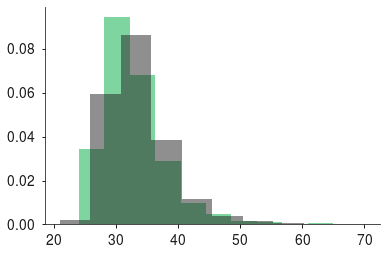

In [48]:
fig, ax = plt.subplots(1, 1)
temp = respondents_zip[~respondents_zip['parents_highest_edu_coded'].isna()]
high_edu = temp[temp['parents_highest_edu_coded'] == doctoral_label]
high_edu_years = (high_edu['Tenure Track Year'] - high_edu['age_coded']).dropna()
high_edu_years.hist(alpha=0.5, color=plot_utils.ACCENT_COLOR, density=True, ax=ax)

low_edu = temp[temp['parents_highest_edu_coded'] != doctoral_label]
low_edu_years = (low_edu['Tenure Track Year'] - low_edu['age_coded']).dropna()
low_edu_years.hist(alpha=0.5, color=plot_utils.ALMOST_BLACK, grid=False, density=True, ax=ax)

print(high_edu_years.mean(), low_edu_years.mean(), len(high_edu_years) + len(low_edu_years),
      ttest_ind(high_edu_years, low_edu_years, equal_var=False))
plot_utils.finalize(ax)

### Distribution of parent's education level by discipline

In [49]:
prof_dist = respondents_zip['parents_highest_edu_coded'].value_counts()
print(prof_dist)

is_prof = [prof_dist[edu_bin].values.sum() for edu_bin in [
    ["Elementary: 0-8 years"], ['High school: 1-3 years'], ['High school: 4 years'],
    ['College: 1-3 years'], ['College: 4+ years'], ["Master's or professional degree"], ['Doctoral degree']]]
print(is_prof, sum(is_prof))

Master's or professional degree    2134
Doctoral degree                    1604
College: 4+ years                  1407
High school: 4 years                987
College: 1-3 years                  683
High school: 1-3 years              210
Elementary: 0-8 years               184
Name: parents_highest_edu_coded, dtype: int64
[184, 210, 987, 683, 1407, 2134, 1604] 7209


In [50]:
fields = respondents_zip['likely_department'].dropna().unique()
field_parent_edu_distribution = {}
edu_bins = [['Elementary: 0-8 years'], ['High school: 1-3 years'], 
            ['High school: 4 years'], ['College: 1-3 years'], ['College: 4+ years'], 
            ["Master's or professional degree"], ['Doctoral degree']]

for field in fields:
    prof_field_dist = respondents_zip[respondents_zip.likely_department == field]['parents_highest_edu_coded'].value_counts()
    if len(prof_field_dist) > 0:
        field_parent_edu_distribution[field] = pd.Series(
            [prof_field_dist.loc[prof_field_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

In [51]:
# Using estimates of educational attainment closest to when faculty were born
is_not_prof = [respondents_zip[edu_bin].values.sum() for edu_bin in [
    ['US_elem_1st-4th', 'US_elem_5th-6th', 'US_elem_7-8th'], ['US_hs_9th', 'US_hs_10th', 'US_hs_11th'], 
    ['US_hs_graduate'], ['US_college_some', 'US_associate_occupational', 'US_associate_academic'], 
    ['US_bachelors'], ['US_masters', 'US_professional_degree'], ['US_doctorate_degree']]]
is_not_prof

[698.6758394943125,
 844.7197230856646,
 2850.3015059241898,
 1853.7040175930424,
 1169.075227696178,
 521.9898908027701,
 70.53379540384154]

In [52]:
# Using estimates of parents education levels among doctoral recipients 
is_phd = [respondents_zip[edu_bin].values.sum() for edu_bin in [
    ['NSF_SED_high_school_or_less'], ['NSF_SED_some_college'], ["NSF_SED_bachelor's_degree"], 
    ["NSF_SED_master's_degree", 'NSF_SED_professional_degree'], ['NSF_SED_research_doctoral_degree']]]
print(is_phd)
print(['HS or less'], ['< College'], ["College"], ['Masters + professional'], ['PhD'])
print(['%.1f' % x for x in (100.*np.array(is_phd))/sum(is_phd)])

[201478.59999999998, 111754.69999999998, 184255.8, 207439.90000000002, 94222.1]
['HS or less'] ['< College'] ['College'] ['Masters + professional'] ['PhD']
['25.2', '14.0', '23.1', '26.0', '11.8']


In [53]:
education_prior = pd.DataFrame([
    is_prof/sum(is_prof), 
    field_parent_edu_distribution['Anthropology']/sum(field_parent_edu_distribution['Anthropology']),
    field_parent_edu_distribution['Biology']/sum(field_parent_edu_distribution['Biology']), 
    field_parent_edu_distribution['Business']/sum(field_parent_edu_distribution['Business']), 
    field_parent_edu_distribution['Computer Science']/sum(field_parent_edu_distribution['Computer Science']),
    field_parent_edu_distribution['History']/sum(field_parent_edu_distribution['History']), 
    field_parent_edu_distribution['Physics and/or Astronomy']/sum(field_parent_edu_distribution['Physics and/or Astronomy']),
    field_parent_edu_distribution['Psychology']/sum(field_parent_edu_distribution['Psychology']),
    field_parent_edu_distribution['Sociology']/sum(field_parent_edu_distribution['Sociology']),
    is_not_prof/sum(is_not_prof)],
    index = ['All Professors', 'Anthropology Professors', 'Biology Professors', 'Business Professors', 
             'CS Professors', 'History Professors', 'Physics/Astronomy Professors', 'Psychology Professors', 
             'Sociology Professors',  'U.S. Population'],     
    columns = ['Elementary', '< HS', 'HS', '< College', 'College', 'Masters', 'PhD'])

print(education_prior.applymap(lambda x: x*100).to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Elementary &  < HS &   HS &  < College &  College &  Masters &  PhD \\
\midrule
All Professors               &         2.6 &   2.9 & 13.7 &        9.5 &     19.5 &     29.6 & 22.2 \\
Anthropology Professors      &         0.8 &   2.3 & 14.9 &        7.3 &     19.4 &     32.1 & 23.1 \\
Biology Professors           &         3.2 &   3.3 & 14.3 &       11.6 &     19.5 &     26.2 & 21.9 \\
Business Professors          &         2.3 &   3.3 & 14.5 &        8.4 &     24.1 &     30.9 & 16.6 \\
CS Professors                &         3.2 &   3.4 & 10.8 &        8.9 &     21.6 &     26.1 & 26.0 \\
History Professors           &         1.6 &   1.3 & 10.5 &        8.6 &     17.0 &     34.3 & 26.7 \\
Physics/Astronomy Professors &         4.1 &   4.1 & 12.1 &       10.2 &     18.3 &     27.3 & 24.1 \\
Psychology Professors        &         1.6 &   2.1 & 17.4 &        9.9 &     17.1 &     31.1 & 20.8 \\
Sociology Professors         &         1.8 &   2.7 & 17

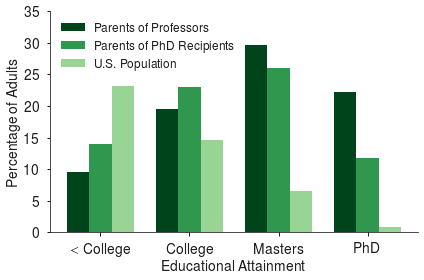

In [54]:
temp = 100.*education_prior.loc[['All Professors', 'U.S. Population']]
nsf_sed_temp = [x for x in (100.*np.array(is_phd))/sum(is_phd)]
nsf_sed_temp.insert(0, None)
nsf_sed_temp.insert(0, None)
temp = temp.append(dict(zip(education_prior.columns, nsf_sed_temp)), ignore_index=True)
temp.index = ['All Professors', 'U.S. Population', 'Doctoral Recipients']

fig, ax = plt.subplots(figsize=plot_utils.SINGLE_FIG_SIZE)

subset_cols = ['< College', 'College', 'Masters', 'PhD']
category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 3))[::-1]

ax.set_ylabel('Percentage of Adults', fontsize=plot_utils.LABEL_SIZE)
ax.set_xlabel("Educational Attainment", fontsize=plot_utils.LABEL_SIZE)

x_range = np.array(range(len(subset_cols)))
delta = 0.25; width = 0.25
plt.bar(x=x_range-delta, height=temp.loc['All Professors', subset_cols], width=width, 
        label='Parents of Professors', color=category_colors[0])
plt.bar(x=x_range, height=temp.loc['Doctoral Recipients', subset_cols], width=width,
        label='Parents of PhD Recipients', color=category_colors[1])
plt.bar(x=x_range+delta, height=temp.loc['U.S. Population', subset_cols], width=width,
        label='U.S. Population', color=category_colors[2])

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([r'$<$ College', 'College', 'Masters', 'PhD'], fontsize=plot_utils.TICK_SIZE)
plt.ylim(0, 35)

plt.legend(frameon=False, loc='upper left', fontsize=plot_utils.LEGEND_SIZE)
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/educational_attainment_comparison.pdf', dpi=500)

Adding NSF doctoral recipient data to the table above.

In [55]:
temp = 100.*education_prior.loc[['Anthropology Professors', 'Biology Professors', 
                                 'Business Professors', 'CS Professors', 
                                 'History Professors', 'Physics/Astronomy Professors', 
                                 'Psychology Professors', 'Sociology Professors', 
                                 'U.S. Population']]
nsf_sed_temp = [x for x in (100.*np.array(is_phd))/sum(is_phd)]
nsf_sed_temp.insert(0, None)
nsf_sed_temp.insert(0, None)
temp = temp.append(dict(zip(education_prior.columns, nsf_sed_temp)), ignore_index=True)
temp.index = ['Anthropology Professors', 'Biology Professors', 'Business Professors', 
              'CS Professors', 'History Professors', 'Physics/Astronomy Professors', 
              'Psychology Professors', 'Sociology Professors', 'U.S. Population', 
              'Doctoral Recipients']
temp

,Elementary,< HS,HS,< College,College,Masters,PhD
Anthropology Professors,0.845070,2.253521,14.929577,7.323944,19.436620,32.112676,23.098592
Biology Professors,3.223727,3.288201,14.313346,11.605416,19.471309,26.241135,21.856867
Business Professors,2.261554,3.343166,14.454277,8.357915,24.090462,30.875123,16.617502
CS Professors,3.200000,3.400000,10.800000,8.900000,21.600000,26.100000,26.000000
History Professors,1.559020,1.336303,10.467706,8.574610,17.037862,34.298441,26.726058
Physics/Astronomy Professors,4.064171,4.064171,12.085561,10.160428,18.288770,27.272727,24.064171
Psychology Professors,1.634321,2.145046,17.364658,9.908069,17.058223,31.052094,20.837589
Sociology Professors,1.789709,2.684564,17.449664,6.935123,17.002237,35.346756,18.791946
U.S. Population,8.723634,10.547131,35.588732,23.145262,14.597019,6.517541,0.880682
Doctoral Recipients,NaN,NaN,25.211578,13.984176,23.056441,25.957532,11.790273


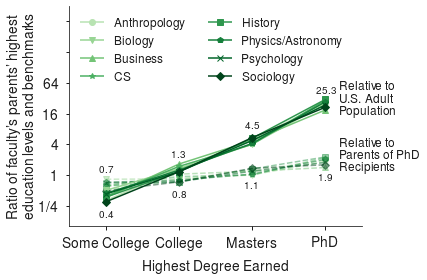

In [56]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE, sharex=True, sharey=True)

subset_cols = ['< College', 'College', 'Masters', 'PhD']
category_colors = plt.get_cmap('Greens')(np.linspace(0.4, 1, 3))[::-1]

ax.set_ylabel("Ratio of faculty's parents' highest\n education levels and benchmarks", 
              fontsize=plot_utils.LABEL_SIZE)
ax.set_xlabel("Highest Degree Earned", fontsize=plot_utils.LABEL_SIZE, labelpad=10)

x_range = np.array(range(len(subset_cols)))
colors = plt.get_cmap('Greens')(np.linspace(0.3, 1, 8))
markers = ["o", "v", "^", "*", "s", "p", "x", "D"]
for i, each in enumerate(['Anthropology Professors', 'Biology Professors', 
                          'Business Professors', 'CS Professors', 'History Professors', 
                          'Physics/Astronomy Professors', 'Psychology Professors', 
                          'Sociology Professors']):
    ratios = temp.loc[each,subset_cols]/temp.loc['Doctoral Recipients',subset_cols]
    ax.plot(x_range, ratios, marker=markers[i], color=colors[i], alpha=0.5, linestyle='--')
               #label=each.split(' ')[0])

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([r'Some College', 'College', 'Masters', 'PhD'], 
                      fontsize=plot_utils.TICK_SIZE)

# subset_cols = ['Elementary', '< HS', 'HS', '< College', 'College', 'Masters', 'PhD']
# x_range = np.array(range(len(subset_cols)))
for i, each in enumerate(['Anthropology Professors', 'Biology Professors', 
                          'Business Professors', 'CS Professors', 'History Professors', 
                          'Physics/Astronomy Professors', 'Psychology Professors', 
                          'Sociology Professors']):
    ratios = temp.loc[each, subset_cols]/temp.loc['U.S. Population', subset_cols]
    ax.plot(x_range, ratios, marker=markers[i], color=colors[i], label=each.split(' ')[0])

# ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
# ax.set_xticklabels(['Elementary', r'$<$ HS', 'HS', r'$<$ College', 'College', 
#                        'Masters', 'PhD'], 
#                       fontsize=plot_utils.TICK_SIZE)

plt.text(3.2, 15, 'Relative to\nU.S. Adult\nPopulation', fontsize=plot_utils.LEGEND_SIZE, ha='left')
plt.text(3.2, 1.2, 'Relative to\nParents of PhD\nRecipients', fontsize=plot_utils.LEGEND_SIZE, ha='left')

ratios = education_prior.loc['All Professors', subset_cols]/education_prior.loc['U.S. Population', subset_cols]
plt.text(0, 0.15, '%.1f' % ratios[0], ha='center')
plt.text(1, 2.25, '%.1f' % ratios[1], ha='center')
plt.text(2, 8.25, '%.1f' % ratios[2], ha='center')
plt.text(3, 40.25, '%.1f' % ratios[3], ha='center')

ratios = (100*education_prior.loc['All Professors', subset_cols])/(temp.loc['Doctoral Recipients', subset_cols])
plt.text(0, 1.15, '%.1f' % ratios[0], ha='center')
plt.text(1, 0.37, '%.1f' % ratios[1], ha='center')
plt.text(2, 0.55, '%.1f' % ratios[2], ha='center')
plt.text(3, 0.8, '%.1f' % ratios[3], ha='center')

plt.ylim(0.1, 2000)
plt.xlim(-0.5, 3.5)
plt.yscale('log', base=2)
ax.set_yticks([1/4, 1, 4, 16, 64, 256, 1024])
ax.set_yticklabels([r'$1/4$', '1', '4', '16', '64', '', ''], fontsize=plot_utils.TICK_SIZE)

ax.legend(frameon=False, fontsize=plot_utils.LEGEND_SIZE, ncol=2, loc='upper left')
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/ratio_education_by_field.pdf', dpi=500)

### Probability that you are a professor, given your parent's education level?

Given $A$ (parent's highest level of education), what is the probability of $B$ (being a professor)? 

$$ P(B = \text{professor} | A = \text{parents' education}) = \frac{P(B = \text{professor}, A = \text{parents' education})}{P(A = \text{parents' education})}$$

The denominator of the above can be obtained from U.S. Census estimates. The conditional probability can be obtained from our survey data.

In [57]:
bus_and_soc = (field_parent_edu_distribution['Business'] + field_parent_edu_distribution['Sociology'])
cs_and_his = (field_parent_edu_distribution['Computer Science'] + field_parent_edu_distribution['History'])

print(sum(cs_and_his) + sum(bus_and_soc))
print(bus_and_soc[6]/sum(bus_and_soc), cs_and_his[6]/sum(cs_and_his))
chi2_contingency([[sum(bus_and_soc[:6]), bus_and_soc[6]], 
                  [sum(cs_and_his[:6]), cs_and_his[6]]], correction=False)

3362
0.17281420765027322 0.26343519494204426


(39.050222919225945,
 4.13041964191722e-10,
 1,
 array([[1136.10232005,  327.89767995],
        [1472.89767995,  425.10232005]]))

In [58]:
for each in education_prior.index:
    print(each, education_prior['PhD'][each]/education_prior['PhD']['U.S. Population'])

All Professors 25.26448084022934
Anthropology Professors 26.228082390733537
Biology Professors 24.818123439738546
Business Professors 18.86890907058132
CS Professors 29.522585422740313
History Professors 30.34701259832823
Physics/Astronomy Professors 27.324482600232702
Psychology Professors 23.660750476306372
Sociology Professors 21.33795539072609
U.S. Population 1.0


### Above results broken down by gender and race

In [59]:
men_prof_dist = respondents_zip[respondents_zip.gender_ans == 'Male']['parents_highest_edu_coded'].value_counts()
men_prof_dist = [men_prof_dist[edu_bin].values.sum() for edu_bin in [
    ["Elementary: 0-8 years"], ['High school: 1-3 years'], ['High school: 4 years'],
    ['College: 1-3 years'], ['College: 4+ years'], ["Master's or professional degree"], ['Doctoral degree']]]

women_prof_dist = respondents_zip[respondents_zip.gender_ans == 'Female']['parents_highest_edu_coded'].value_counts()
women_prof_dist = [women_prof_dist[edu_bin].values.sum() for edu_bin in [
    ["Elementary: 0-8 years"], ['High school: 1-3 years'], ['High school: 4 years'],
    ['College: 1-3 years'], ['College: 4+ years'], ["Master's or professional degree"], ['Doctoral degree']]]

In [60]:
education_prior = pd.DataFrame([
    is_prof/sum(is_prof), 
    men_prof_dist/sum(men_prof_dist),
    women_prof_dist/sum(women_prof_dist)],
    index = ['All Professors', 'Men Professors', 'Women Professors'],     
    columns = ['Elementary', '< HS', 'HS', '< College', 'College', 'Masters', 'PhD'])

education_prior.applymap(lambda x: x*100)
#print(education_prior.applymap(lambda x: x*100).to_latex(float_format="%.1f"))

,Elementary,< HS,HS,< College,College,Masters,PhD
All Professors,2.552365,2.913025,13.691219,9.474268,19.517270,29.601887,22.249965
Men Professors,3.234323,3.410341,14.477448,10.055006,19.757976,28.228823,20.836084
Women Professors,1.341510,2.069759,12.303565,8.317363,19.126102,32.042928,24.798773


In [61]:
print(sum(women_prof_dist[-2:])/sum(women_prof_dist), sum(men_prof_dist[-2:])/sum(men_prof_dist))
proportions_ztest([sum(women_prof_dist[-2:]), sum(men_prof_dist[-2:])],
                  [sum(women_prof_dist), sum(men_prof_dist)])

0.568417018014565 0.49064906490649063


(6.3368628625900625, 2.344905271651895e-10)

In [62]:
respondents_zip.groupby('gender_ans')['parents_had_phd'].agg(['mean', 'count'])

,mean,count
gender_ans,,
Female,0.247988,2609
Male,0.208361,4545
Other identity,0.153846,13
Prefer not to say,0.205128,39


In [63]:
print(sum(women_prof_dist) + sum(men_prof_dist), sum(women_prof_dist[-1:])/sum(women_prof_dist), 
      sum(men_prof_dist[-1:])/sum(men_prof_dist))
proportions_ztest([sum(women_prof_dist[-1:]), sum(men_prof_dist[-1:])],
                  [sum(women_prof_dist), sum(men_prof_dist)])

7154 0.2479877347642775 0.20836083608360836


(3.8769212670564523, 0.00010578657149720745)

In [64]:
fields = respondents_zip['likely_department'].dropna().unique()
field_parent_edu_distribution = {}
edu_bins = [['Elementary: 0-8 years'], ['High school: 1-3 years'], 
            ['High school: 4 years'], ['College: 1-3 years'], ['College: 4+ years'], 
            ["Master's or professional degree"], ['Doctoral degree']]

for field in fields:
    prof_field_dist = respondents_zip[(respondents_zip.likely_department == field) & \
                                      (respondents_zip.gender_ans == 'Female')]['parents_highest_edu_coded'].value_counts()
    if len(prof_field_dist) > 0:
        field_parent_edu_distribution[field] = pd.Series(
            [prof_field_dist.loc[prof_field_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0).values

print(pd.DataFrame([
    field_parent_edu_distribution['Anthropology']/sum(field_parent_edu_distribution['Anthropology']),
    field_parent_edu_distribution['Biology']/sum(field_parent_edu_distribution['Biology']), 
    field_parent_edu_distribution['Business']/sum(field_parent_edu_distribution['Business']), 
    field_parent_edu_distribution['Computer Science']/sum(field_parent_edu_distribution['Computer Science']),
    field_parent_edu_distribution['History']/sum(field_parent_edu_distribution['History']), 
    field_parent_edu_distribution['Physics and/or Astronomy']/sum(field_parent_edu_distribution['Physics and/or Astronomy']),
    field_parent_edu_distribution['Psychology']/sum(field_parent_edu_distribution['Psychology']),
    field_parent_edu_distribution['Sociology']/sum(field_parent_edu_distribution['Sociology'])],
    index = ['Anthropology Women Professors', 'Biology Women Professors', 'Business Women Professors', 
             'CS Women Professors', 'History Women Professors', 'Physics/Astronomy Women Professors', 
             'Psychology Women Professors', 'Sociology Women Professors'],     
    columns = ['Elementary', 'Some HS', 'HS', 'Some College', 'College', 'Masters', 'PhD']).applymap(
    lambda x: x*100).round(1).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Elementary &  Some HS &    HS &  Some College &  College &  Masters &   PhD \\
\midrule
Anthropology Women Professors      &         0.6 &      1.7 &  16.9 &           5.6 &     18.5 &     32.0 &  24.7 \\
Biology Women Professors           &         1.7 &      2.6 &   9.7 &          12.5 &     18.9 &     30.5 &  24.0 \\
Business Women Professors          &         0.3 &      2.4 &  11.9 &           7.6 &     26.5 &     32.3 &  18.9 \\
CS Women Professors                &         1.5 &      1.5 &  11.3 &           4.9 &     28.1 &     21.7 &  31.0 \\
History Women Professors           &         1.7 &      1.2 &   7.9 &           5.7 &     15.3 &     37.3 &  30.9 \\
Physics/Astronomy Women Professors &         3.3 &      3.8 &   7.7 &          12.0 &     13.1 &     31.1 &  29.0 \\
Psychology Women Professors        &         0.8 &      1.7 &  17.1 &           8.8 &     17.1 &     31.2 &  23.3 \\
Sociology Women Professors         &         1.7 &  

In [65]:
fields = respondents_zip['likely_department'].dropna().unique()
field_parent_edu_distribution = {}
edu_bins = [['Elementary: 0-8 years'], ['High school: 1-3 years'], 
            ['High school: 4 years'], ['College: 1-3 years'], ['College: 4+ years'], 
            ["Master's or professional degree"], ['Doctoral degree']]

for field in fields:
    prof_field_dist = respondents_zip[(respondents_zip.likely_department == field) & \
                                      (respondents_zip.gender_ans == 'Male')]['parents_highest_edu_coded'].value_counts()
    if len(prof_field_dist) > 0:
        field_parent_edu_distribution[field] = pd.Series(
            [prof_field_dist.loc[prof_field_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0).values

print(pd.DataFrame([ 
    field_parent_edu_distribution['Anthropology']/sum(field_parent_edu_distribution['Anthropology']),
    field_parent_edu_distribution['Biology']/sum(field_parent_edu_distribution['Biology']), 
    field_parent_edu_distribution['Business']/sum(field_parent_edu_distribution['Business']), 
    field_parent_edu_distribution['Computer Science']/sum(field_parent_edu_distribution['Computer Science']),
    field_parent_edu_distribution['History']/sum(field_parent_edu_distribution['History']), 
    field_parent_edu_distribution['Physics and/or Astronomy']/sum(field_parent_edu_distribution['Physics and/or Astronomy']),
    field_parent_edu_distribution['Psychology']/sum(field_parent_edu_distribution['Psychology']),
    field_parent_edu_distribution['Sociology']/sum(field_parent_edu_distribution['Sociology'])],
    index = ['Anthropology Men Professors', 'Biology Men Professors', 'Business Men Professors', 
             'CS Men Professors', 'History Men Professors', 'Physics/Astronomy Men Professors', 
             'Psychology Men Professors', 'Sociology Men Professors'],     
    columns = ['Elementary', 'Some HS', 'HS', 'Some College', 'College', 'Masters', 'PhD']).applymap(
    lambda x: x*100).round(1).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Elementary &  Some HS &    HS &  Some College &  College &  Masters &   PhD \\
\midrule
Anthropology Men Professors      &         1.2 &      2.9 &  13.3 &           8.7 &     20.2 &     31.8 &  22.0 \\
Biology Men Professors           &         3.9 &      3.7 &  16.7 &          11.2 &     19.8 &     23.8 &  20.9 \\
Business Men Professors          &         3.2 &      3.7 &  15.8 &           8.8 &     23.0 &     29.9 &  15.6 \\
CS Men Professors                &         3.7 &      3.9 &  10.7 &           9.8 &     19.8 &     27.4 &  24.7 \\
History Men Professors           &         1.5 &      1.5 &  12.8 &          10.7 &     18.5 &     31.9 &  23.1 \\
Physics/Astronomy Men Professors &         4.3 &      4.2 &  13.1 &           9.4 &     19.6 &     26.3 &  23.1 \\
Psychology Men Professors        &         2.6 &      2.6 &  17.4 &          11.2 &     17.1 &     31.2 &  17.8 \\
Sociology Men Professors         &         2.0 &      3.4 &  17.6 

In [66]:
stem_field = respondents_zip.likely_department.isin(['Physics and/or Astronomy', 'Computer Science', 'Psychology'])
women_stem_prof_dist = respondents_zip[(respondents_zip.gender_ans == 'Female') & stem_field]['parents_highest_edu_coded'].value_counts()
women_stem_prof_dist = [women_stem_prof_dist[edu_bin].values.sum() for edu_bin in [
    ["Elementary: 0-8 years"], ['High school: 1-3 years'], ['High school: 4 years'],
    ['College: 1-3 years'], ['College: 4+ years'], ["Master's or professional degree"], ['Doctoral degree']]]

women_not_stem_prof_dist = respondents_zip[(respondents_zip.gender_ans == 'Female') & ~stem_field]['parents_highest_edu_coded'].value_counts()
women_not_stem_prof_dist = [women_not_stem_prof_dist[edu_bin].values.sum() for edu_bin in [
    ["Elementary: 0-8 years"], ['High school: 1-3 years'], ['High school: 4 years'],
    ['College: 1-3 years'], ['College: 4+ years'], ["Master's or professional degree"], ['Doctoral degree']]]

In [67]:
education_prior = pd.DataFrame([
    is_prof/sum(is_prof), 
    women_stem_prof_dist/sum(women_stem_prof_dist),
    women_not_stem_prof_dist/sum(women_not_stem_prof_dist),
    women_prof_dist/sum(women_prof_dist)],
    index = ['All Professors', 'Women STEM Professors', 'Women non-STEM Professors', 'Women Professors'],     
    columns = ['Elementary', 'Some HS', 'HS', 'Some College', 'College', 'Masters', 'PhD'])
education_prior.applymap(lambda x: x*100)
# print(education_prior.applymap(lambda x: x*100).to_latex(float_format="%.1f"))

,Elementary,Some HS,HS,Some College,College,Masters,PhD
All Professors,2.552365,2.913025,13.691219,9.474268,19.517270,29.601887,22.249965
Women STEM Professors,1.434879,2.097130,13.907285,8.609272,18.763797,29.028698,26.158940
Women non-STEM Professors,1.291838,2.055197,11.450382,8.162067,19.318849,33.646506,24.075161
Women Professors,1.341510,2.069759,12.303565,8.317363,19.126102,32.042928,24.798773


In [68]:
white_prof_dist = respondents_zip[respondents_zip.white == 1]['parents_highest_edu_coded'].value_counts()
white_prof_dist = pd.Series([white_prof_dist.loc[white_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

black_prof_dist = respondents_zip[respondents_zip.black == 1]['parents_highest_edu_coded'].value_counts()
black_prof_dist = pd.Series([black_prof_dist.loc[black_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

hisp_prof_dist = respondents_zip[respondents_zip.hisp == 1]['parents_highest_edu_coded'].value_counts()
hisp_prof_dist = pd.Series([hisp_prof_dist.loc[hisp_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

asian_prof_dist = respondents_zip[respondents_zip.asian == 1]['parents_highest_edu_coded'].value_counts()
asian_prof_dist = pd.Series([asian_prof_dist.loc[asian_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

native_prof_dist = respondents_zip[(respondents_zip.native == 1) | (respondents_zip.hawaii == 1)]['parents_highest_edu_coded'].value_counts()
native_prof_dist = pd.Series([native_prof_dist.loc[native_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

In [69]:
sum(white_prof_dist), sum(black_prof_dist), sum(hisp_prof_dist)

(5905, 198, 320)

In [70]:
education_prior = pd.DataFrame([
    is_prof/sum(is_prof), 
    white_prof_dist/sum(white_prof_dist),
    black_prof_dist/sum(black_prof_dist),
    hisp_prof_dist/sum(hisp_prof_dist), 
    asian_prof_dist/sum(asian_prof_dist), 
    native_prof_dist/sum(native_prof_dist)],
    index = ['All Professors', 'White Professors', 'Black Professors', 'Hispanic Professors', 
             'Asian Professors', 'American Indian / Native Professors'],     
    columns = ['Elementary', '< HS', 'HS', '< College', 'College', 'Masters', 'PhD'])

education_prior.applymap(lambda x: x*100)#)#.to_latex(float_format="%.1f"))

,Elementary,< HS,HS,< College,College,Masters,PhD
All Professors,2.552365,2.913025,13.691219,9.474268,19.517270,29.601887,22.249965
White Professors,1.828959,2.167655,14.072820,8.738357,19.305673,30.533446,23.353091
Black Professors,6.060606,4.040404,16.666667,13.636364,10.606061,31.818182,17.171717
Hispanic Professors,5.000000,4.687500,15.937500,11.875000,16.875000,28.750000,16.875000
Asian Professors,5.668016,7.017544,7.422402,12.550607,23.211876,25.775978,18.353576
American Indian / Native Professors,0.000000,4.166667,18.750000,10.416667,16.666667,37.500000,12.500000


In [71]:
poc_prof_dist = respondents_zip[(respondents_zip.black == 1) | (respondents_zip.hisp == 1)]['parents_highest_edu_coded'].value_counts()
poc_prof_dist = pd.Series([poc_prof_dist.loc[edu_bin].values.sum() for edu_bin in edu_bins]).fillna(0)

print((white_prof_dist/sum(white_prof_dist)))
print((poc_prof_dist/sum(poc_prof_dist)))

0    0.018290
1    0.021677
2    0.140728
3    0.087384
4    0.193057
5    0.305334
6    0.233531
dtype: float64
0    0.053571
1    0.043651
2    0.162698
3    0.125000
4    0.144841
5    0.299603
6    0.170635
dtype: float64


In [72]:
white_prof_dist = respondents_zip[(respondents_zip.white == 1) & 
                                  (respondents_zip.gender_ans == 'Female')]['parents_highest_edu_coded'].value_counts()
white_prof_dist = pd.Series([white_prof_dist.loc[white_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

black_prof_dist = respondents_zip[(respondents_zip.black == 1) & 
                                  (respondents_zip.gender_ans == 'Female')]['parents_highest_edu_coded'].value_counts()
black_prof_dist = pd.Series([black_prof_dist.loc[black_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

hisp_prof_dist = respondents_zip[(respondents_zip.hisp == 1) & 
                                 (respondents_zip.gender_ans == 'Female')]['parents_highest_edu_coded'].value_counts()
hisp_prof_dist = pd.Series([hisp_prof_dist.loc[hisp_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

asian_prof_dist = respondents_zip[(respondents_zip.asian == 1) & 
                                  (respondents_zip.gender_ans == 'Female')]['parents_highest_edu_coded'].value_counts()
asian_prof_dist = pd.Series([asian_prof_dist.loc[asian_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

native_prof_dist = respondents_zip[((respondents_zip.native == 1) | (respondents_zip.hawaii == 1)) &
                                   (respondents_zip.gender_ans == 'Female')]['parents_highest_edu_coded'].value_counts()
native_prof_dist = pd.Series([native_prof_dist.loc[native_prof_dist.index.intersection(edu_bin)].values.sum() 
             for edu_bin in edu_bins]).fillna(0)

In [73]:
education_prior = pd.DataFrame([
    white_prof_dist/sum(white_prof_dist),
    black_prof_dist/sum(black_prof_dist),
    hisp_prof_dist/sum(hisp_prof_dist), 
    asian_prof_dist/sum(asian_prof_dist), 
    native_prof_dist/sum(native_prof_dist)],
    index = ['White Women Professors', 'Black Women Professors', 
             'Hispanic Women Professors', 'Asian Women Professors', 
             'American Indian / Native Women Professors'])

# print(education_prior)
print(education_prior.applymap(lambda x: x*100).to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &   0 &   1 &    2 &    3 &    4 &    5 &    6 \\
\midrule
White Women Professors                    & 0.9 & 1.7 & 12.1 &  7.3 & 19.5 & 32.9 & 25.5 \\
Black Women Professors                    & 4.9 & 0.0 & 17.5 & 14.6 & 11.7 & 36.9 & 14.6 \\
Hispanic Women Professors                 & 2.3 & 2.3 & 13.7 & 15.3 & 15.3 & 31.3 & 19.8 \\
Asian Women Professors                    & 2.4 & 4.4 &  7.3 & 12.5 & 19.4 & 30.2 & 23.8 \\
American Indian / Native Women Professors & 0.0 & 5.3 & 21.1 & 10.5 & 10.5 & 36.8 & 15.8 \\
\bottomrule
\end{tabular}



In [74]:
white_prof_dist = respondents_zip[(respondents_zip.white == 1) & \
                                  (respondents_zip.gender_ans == 'Male')]['parents_highest_edu_coded'].value_counts()
white_prof_dist = pd.Series([white_prof_dist.loc[white_prof_dist.index.intersection(edu_bin)].values.sum() 
                             for edu_bin in edu_bins]).fillna(0)

black_prof_dist = respondents_zip[(respondents_zip.black == 1) & \
                                  (respondents_zip.gender_ans == 'Male')]['parents_highest_edu_coded'].value_counts()
black_prof_dist = pd.Series([black_prof_dist.loc[black_prof_dist.index.intersection(edu_bin)].values.sum() 
                             for edu_bin in edu_bins]).fillna(0)

hisp_prof_dist = respondents_zip[(respondents_zip.hisp == 1) & \
                                  (respondents_zip.gender_ans == 'Male')]['parents_highest_edu_coded'].value_counts()
hisp_prof_dist = pd.Series([hisp_prof_dist.loc[hisp_prof_dist.index.intersection(edu_bin)].values.sum() 
                             for edu_bin in edu_bins]).fillna(0)

asian_prof_dist = respondents_zip[(respondents_zip.asian == 1) & \
                                  (respondents_zip.gender_ans == 'Male')]['parents_highest_edu_coded'].value_counts()
asian_prof_dist = pd.Series([asian_prof_dist.loc[asian_prof_dist.index.intersection(edu_bin)].values.sum() 
                             for edu_bin in edu_bins]).fillna(0)

native_prof_dist = respondents_zip[((respondents_zip.native == 1) | (respondents_zip.hawaii == 1)) & \
                                   (respondents_zip.gender_ans == 'Male')]['parents_highest_edu_coded'].value_counts()
native_prof_dist = pd.Series([native_prof_dist.loc[native_prof_dist.index.intersection(edu_bin)].values.sum() 
                             for edu_bin in edu_bins]).fillna(0)

In [75]:
education_prior = pd.DataFrame([
    white_prof_dist/sum(white_prof_dist),
    black_prof_dist/sum(black_prof_dist),
    hisp_prof_dist/sum(hisp_prof_dist), 
    asian_prof_dist/sum(asian_prof_dist), 
    native_prof_dist/sum(native_prof_dist)],
    index = ['White Men Professors', 'Black Men Professors', 
             'Hispanic Men Professors', 'Asian Men Professors', 
             'American Indian / Native Men Professors'])

print(education_prior.applymap(lambda x: x*100).to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &   0 &   1 &    2 &    3 &    4 &    5 &    6 \\
\midrule
White Men Professors                    & 2.4 & 2.5 & 15.2 &  9.6 & 19.2 & 29.1 & 22.0 \\
Black Men Professors                    & 7.4 & 8.4 & 15.8 & 12.6 &  9.5 & 26.3 & 20.0 \\
Hispanic Men Professors                 & 6.9 & 6.4 & 17.0 &  9.6 & 18.1 & 27.1 & 14.9 \\
Asian Men Professors                    & 7.3 & 8.4 &  7.5 & 12.4 & 25.3 & 23.4 & 15.7 \\
American Indian / Native Men Professors & 0.0 & 3.4 & 17.2 & 10.3 & 20.7 & 37.9 & 10.3 \\
\bottomrule
\end{tabular}



### Features of faculty without PhDs

Are there concentrated more in some disciplines? Did they grow in particular areas of the country (urban, rural, particular states, perhaps reflecting different quality of basic education)? Those of them who managed to get to high prestige places - did they get more support when they were younger? Were they more often men, particular race? Were they richer?

In [76]:
temp = respondents_zip[~respondents_zip.parents_had_phd.isna()].copy()
temp['parents_had_phd'] = temp['parents_had_phd'].astype(bool)
non_phd_depts = temp[~temp.parents_had_phd].likely_department.value_counts(normalize=True)
yes_phd_depts = temp[temp.parents_had_phd].likely_department.value_counts(normalize=True)

In [77]:
yes_phd_depts

Biology                     0.211478
Computer Science            0.162196
History                     0.149719
Physics and/or Astronomy    0.140362
Psychology                  0.127261
Business                    0.105427
Sociology                   0.052402
Anthropology                0.051154
Name: likely_department, dtype: float64

In [78]:
non_phd_depts

Biology                     0.217243
Business                    0.151999
Psychology                  0.138914
Computer Science            0.132640
Physics and/or Astronomy    0.127263
History                     0.117942
Sociology                   0.065065
Anthropology                0.048934
Name: likely_department, dtype: float64

In [79]:
non_phd_income = temp[~temp.parents_had_phd].avg_income
yes_phd_income = temp[temp.parents_had_phd].avg_income

In [80]:
non_phd_income.median(), yes_phd_income.median()

(70.2083475394786, 81.31856450515383)

In [81]:
non_phd_ruca = temp[~temp.parents_had_phd].ru_class.value_counts(normalize=True)
yes_phd_ruca = temp[temp.parents_had_phd].ru_class.value_counts(normalize=True)

In [82]:
non_phd_ruca, yes_phd_ruca

(urban    0.880537
 rural    0.119463
 Name: ru_class, dtype: float64,
 urban    0.94509
 rural    0.05491
 Name: ru_class, dtype: float64)

In [83]:
temp['support_sum'] = temp[['support_collsin', 'support_collsout', 'support_partner', 'support_friends',
                            'support_family', 'support_parents']].sum(axis=1)
temp['support_avg'] = temp[['support_collsin', 'support_collsout', 'support_partner', 'support_friends',
                            'support_family','support_parents']].mean(axis=1)

In [84]:
temp.groupby('parents_had_phd')[['support_collsin', 'support_collsout', 'support_partner', 'support_friends', 
                                 'support_family', 'support_parents', 'support_sum', 'support_avg']].mean()

,support_collsin,support_collsout,support_partner,support_friends,support_family,support_parents,support_sum,support_avg
parents_had_phd,,,,,,,,
False,3.834345,3.930081,4.501171,3.249826,3.365917,3.896320,17.723461,3.800119
True,3.935355,4.051834,4.500835,3.479132,3.754877,4.457053,18.488155,4.032960


In [85]:
temp.groupby('parents_had_phd')[['white', 'black', 'hisp', 'asian', 'native', 'hawaii']].mean()

,white,black,hisp,asian,native,hawaii
parents_had_phd,,,,,,
False,0.807493,0.029260,0.047458,0.107939,0.006423,0.001070
True,0.859726,0.021197,0.033666,0.084788,0.003117,0.000623


In [86]:
alpha = 0.20

field_pi = temp.groupby('likely_department').rank_scaled.quantile(alpha)
top_pi = temp.likely_department.apply(lambda x: field_pi[x] if x in field_pi else np.nan)

temp['top_20_perc'] = (~temp.rank_scaled.isna() & ~temp.likely_department.isna() & (temp.rank_scaled < top_pi))

temp.groupby(['parents_had_phd', 'top_20_perc'])[['support_collsin', 'support_collsout', 'support_partner', 
                                                  'support_friends', 'support_family', 'support_parents', 
                                                  'support_sum', 'support_avg']].mean()

support_collsin  support_collsout  \
parents_had_phd top_20_perc                                      
False           False               3.809924          3.913318   
                True                3.979687          4.029641   
True            False               3.925447          4.056604   
                True                3.975709          4.032389   

                             support_partner  support_friends  support_family  \
parents_had_phd top_20_perc                                                     
False           False               4.500958         3.250406        3.369192   
                True                4.502431         3.246330        3.346470   
True            False               4.510417         3.484536        3.770594   
                True                4.462185         3.456140        3.686364   

                             support_parents  support_sum  support_avg  
parents_had_phd top_20_perc                                             
False           False               3.906849    17.742010     3.794499  
                True                3.834109    17.614914     3.833939  
True            False               4.490695    18.884069     4.042745  
                True                4.318548    16.994048     3.992622

In [87]:
print(len(temp[~temp.parents_had_phd & temp.top_20_perc]['support_collsin'].dropna()) + \
      len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_collsin'].dropna()))

print(ttest_ind(temp[~temp.parents_had_phd & temp.top_20_perc]['support_collsin'].dropna(),
                temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_collsin'].dropna(), equal_var=False))

r = sms.CompareMeans(
    sms.DescrStatsW(temp[~temp.parents_had_phd & temp.top_20_perc]['support_collsin'].dropna()), 
    sms.DescrStatsW(temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_collsin'].dropna()))
print(r.tconfint_diff(usevar='unequal'))

4449
Ttest_indResult(statistic=3.6345100813411557, pvalue=0.00029417582111712854)
(0.07809365686434276, 0.26143361407291066)


In [88]:
print(len(temp[~temp.parents_had_phd & temp.top_20_perc]['support_collsout'].dropna()) + \
      len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_collsout'].dropna()))

print(ttest_ind(temp[~temp.parents_had_phd & temp.top_20_perc]['support_collsout'].dropna(),
                temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_collsout'].dropna(), equal_var=False))

r = sms.CompareMeans(
    sms.DescrStatsW(temp[~temp.parents_had_phd & temp.top_20_perc]['support_collsout'].dropna()), 
    sms.DescrStatsW(temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_collsout'].dropna()))
print(r.tconfint_diff(usevar='unequal'))

4448
Ttest_indResult(statistic=2.5942970398400096, pvalue=0.00963300138799685)
(0.02832367520005924, 0.20432355031071087)


In [89]:
ttest_ind(
    temp[~temp.parents_had_phd & temp.top_20_perc]['support_parents'].dropna(),
    temp[~temp.parents_had_phd & ~temp.top_20_perc]['support_parents'].dropna(),
    equal_var=False
)

Ttest_indResult(statistic=-1.3499506512190365, pvalue=0.17738687561823943)

In [90]:
temp.groupby(['parents_had_phd', 'top_20_perc'])[['white', 'black', 'hisp', 'asian', 'native', 'hawaii']].mean()

white     black      hisp     asian    native  \
parents_had_phd top_20_perc                                                     
False           False        0.804888  0.029246  0.047838  0.110508  0.006058   
                True         0.822738  0.029340  0.045232  0.092910  0.008557   
True            False        0.858044  0.018927  0.034700  0.089117  0.002366   
                True         0.866071  0.029762  0.029762  0.068452  0.005952   

                               hawaii  
parents_had_phd top_20_perc            
False           False        0.001253  
                True         0.000000  
True            False        0.000789  
                True         0.000000

In [91]:
ttest_ind(
    temp[~temp.parents_had_phd & temp.top_20_perc]['white'].dropna(),
    temp[~temp.parents_had_phd & ~temp.top_20_perc]['white'].dropna(),
    equal_var=False
)

Ttest_indResult(statistic=1.2279249718242102, pvalue=0.21972895812047086)

In [92]:
temp.groupby(['parents_had_phd', 'top_20_perc'])['gender_ans'].value_counts(normalize=True)

parents_had_phd  top_20_perc  gender_ans       
False            False        Male                 0.641095
                              Female               0.351380
                              Prefer not to say    0.005435
                              Other identity       0.002090
                 True         Male                 0.649144
                              Female               0.343521
                              Prefer not to say    0.006112
                              Other identity       0.001222
True             False        Male                 0.582019
                              Female               0.412461
                              Prefer not to say    0.004732
                              Other identity       0.000789
                 True         Male                 0.622024
                              Female               0.369048
                              Prefer not to say    0.005952
                              Other identity       0

In [93]:
temp.groupby(['parents_had_phd', 'top_20_perc'])['avg_income'].agg('median')

parents_had_phd  top_20_perc
False            False          68.947844
                 True           80.030364
True             False          78.884450
                 True           89.682769
Name: avg_income, dtype: float64

In [94]:
print(len(temp[~temp.parents_had_phd & temp.top_20_perc]['avg_income'].dropna()) + 
      len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['avg_income'].dropna()))
U1, p = mannwhitneyu(
    temp[~temp.parents_had_phd & temp.top_20_perc]['avg_income'].dropna(),
    temp[~temp.parents_had_phd & ~temp.top_20_perc]['avg_income'].dropna()
)
print(U1, p)

n1 = len(temp[~temp.parents_had_phd & temp.top_20_perc]['avg_income'].dropna())
n2 = len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['avg_income'].dropna())
U2 = n1*n2 - U1
print(min(U1, U2)/(n1*n2))

2974
462471.0 5.561573167752722e-08
0.4203315055719003


In [95]:
temp.groupby(['parents_had_phd', 'top_20_perc'])['ru_class'].value_counts(normalize=True)

parents_had_phd  top_20_perc  ru_class
False            False        urban       0.873433
                              rural       0.126567
                 True         urban       0.922897
                              rural       0.077103
True             False        urban       0.946667
                              rural       0.053333
                 True         urban       0.939086
                              rural       0.060914
Name: ru_class, dtype: float64

In [96]:
proportions_ztest(
    [sum(temp[~temp.parents_had_phd & temp.top_20_perc]['ru_class']=='urban'),
     sum(temp[~temp.parents_had_phd & ~temp.top_20_perc]['ru_class']=='urban')],
    [len(temp[~temp.parents_had_phd & temp.top_20_perc]['ru_class'].dropna()),
     len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['ru_class'].dropna())]
)

(2.9198321710165445, 0.003502199368949154)

In [97]:
temp.groupby(['parents_had_phd'])['phd_rank_scaled'].mean()

parents_had_phd
False    19.416564
True     13.606420
Name: phd_rank_scaled, dtype: float64

In [98]:
print(len(temp[temp.parents_had_phd]['phd_rank_scaled'].dropna()) +
      len(temp[~temp.parents_had_phd]['phd_rank_scaled'].dropna()))

print(temp[temp.parents_had_phd]['phd_rank_scaled'].dropna().median(), 
      temp[~temp.parents_had_phd]['phd_rank_scaled'].dropna().median())

U1, p = mannwhitneyu(
    temp[temp.parents_had_phd]['phd_rank_scaled'].dropna(),
    temp[~temp.parents_had_phd]['phd_rank_scaled'].dropna()
)
print(U1, p)

n1 = len(temp[temp.parents_had_phd]['phd_rank_scaled'].dropna())
n2 = len(temp[~temp.parents_had_phd]['phd_rank_scaled'].dropna())
U2 = n1*n2 - U1
print(min(U1, U2)/(n1*n2))

4906
7.07070707070707 11.643835616438356
1684329.5 1.8746915709585328e-22
0.4041476779611523


In [99]:
temp.groupby(['parents_had_phd', 'top_20_perc'])['phd_rank_scaled'].mean()

parents_had_phd  top_20_perc
False            False          21.136079
                 True            9.753249
True             False          15.380993
                 True            6.442706
Name: phd_rank_scaled, dtype: float64

In [100]:
print(len(temp[~temp.parents_had_phd & temp.top_20_perc]['phd_rank_scaled'].dropna()) +  
      len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['phd_rank_scaled'].dropna()))

print(temp[~temp.parents_had_phd & temp.top_20_perc]['phd_rank_scaled'].dropna().mean(), 
      temp[~temp.parents_had_phd & ~temp.top_20_perc]['phd_rank_scaled'].dropna().mean())

print(temp[~temp.parents_had_phd & temp.top_20_perc]['phd_rank_scaled'].dropna().median(), 
      temp[~temp.parents_had_phd & ~temp.top_20_perc]['phd_rank_scaled'].dropna().median())

U1, p = mannwhitneyu(
    temp[~temp.parents_had_phd & temp.top_20_perc]['phd_rank_scaled'].dropna(),
    temp[~temp.parents_had_phd & ~temp.top_20_perc]['phd_rank_scaled'].dropna()
)
print(U1, p)

n1 = len(temp[~temp.parents_had_phd & temp.top_20_perc]['phd_rank_scaled'].dropna())
n2 = len(temp[~temp.parents_had_phd & ~temp.top_20_perc]['phd_rank_scaled'].dropna())
U2 = n1*n2 - U1
print(min(U1, U2)/(n1*n2))

3813
9.753248616253169 21.13607913121521
5.531914893617021 14.042553191489363
584657.0 1.4546374074296715e-46
0.3135710577352144


In [101]:
alpha = 0.005
full_temp = temp[~temp.parents_had_phd][['top_20_perc', 'phd_rank_scaled']].dropna().append(
    temp[~temp.parents_had_phd][['top_20_perc', 'phd_rank_scaled']].dropna())

test_stats = np.array([])
for i in range(1000):
    sampled = full_temp.sample(frac = 1, replace = True)    
    t, p = mannwhitneyu(sampled[sampled.top_20_perc]['phd_rank_scaled'].dropna(),
                        sampled[~sampled.top_20_perc]['phd_rank_scaled'].dropna())
    test_stats = np.append(test_stats, t)
    
print(np.quantile(test_stats, alpha/2), np.quantile(test_stats, 1 - (alpha/2)))

2137830.81625 2556367.3725000015
